Mounting google drive:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


import libraries:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os

check if gpu is enabled

In [ ]:
# Confirms enabled GPU
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


set seed to get consistent results over multiple runs

In [ ]:
# To get consistent results
np.random.seed(69) 

utility functions:

In [ ]:
def get_training_df():
    training_df = pd.read_csv(r'/content/gdrive/My Drive/vcs/training.csv')
    return training_df


def get_test_df():
    test_df = pd.read_csv(r'/content/gdrive/My Drive/vcs/test.csv')
    return test_df

def drop_na_values(df):
    dropped_df = df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
    return dropped_df

def get_images(df):
    images = df['Image']
    images_list = []
    for img in images:
        images_list.append(np.array([int(x) for x in img.split(' ')]).reshape((96, 96)))
    return np.array(images_list) / 255.0   # Normalize pixel values between (0, 1)

# Delete image row to turn dataset to an array
def drop_pixel_values(df):
    new_df = df.drop(['Image'], axis=1)
    return new_df

def drop_x_values(df):
    lst = []
    for i in df:
        if 'x' in i:
            lst.append(i)
    return df.drop(columns=lst, axis=1)
  
def image_mirroring(df):
    all_images = get_images(df)
    return np.array([np.fliplr(image) for image in all_images])

def x_feature_mirroring(df, width=96):
    x_features = {}
    for column in df:
        if 'x' in column:
            temp = np.array(df[column])
            temp = width - temp
            x_features[column] = temp
    return x_features

def data_augmentation(df):
    augmented_images = image_mirroring(df)
    augmented_xes = x_feature_mirroring(df, width=96)

    # Drops x values to feed new augmented x values to dataframe
    df = drop_x_values(df)
    del df['Image']
    for name, j in zip(augmented_xes, range(0, 30, 2)):
        df.insert(loc=j, column=name, value=augmented_xes[name])

    augmented_df = df

    return augmented_df, augmented_images

# Shows image and keypoints at given index
def show_image(x_dataset, y_dataset, index): 
    img = np.array(x_dataset[index]).reshape((96, 96))
    keypoints = y_dataset[index]
    x_keypoints = keypoints[::2]
    y_keypoints = keypoints[1::2]
    plt.imshow(img, cmap='gray')
    plt.scatter(x_keypoints, y_keypoints)
    plt.show()


  Facial keypoint detection

In [ ]:
# Get training dataframe
training_dataframe = get_training_df()

# Drop rows which have NaN values
training_dataframe_dropped = drop_na_values(training_dataframe)

# Extract images from dataframe
training_images = get_images(training_dataframe_dropped)

# Extract keypoints from dataframe
training_dataframe_keypoints = drop_pixel_values(training_dataframe_dropped)
training_array = training_dataframe_keypoints.to_numpy(dtype='float32', copy=False)

# Augment images and keypoints
augmented_training_dataframe, augmented_training_images = data_augmentation(training_dataframe_dropped)
augmented_training_array = augmented_training_dataframe.to_numpy(dtype='float32', copy=False)

# Concatenate real and augmented values
training_Y = np.concatenate((training_array, augmented_training_array), axis=0)
training_X = np.concatenate((training_images, augmented_training_images), axis=0)

# Concatenate X and y values
training_dataset = np.concatenate((training_X.reshape((4280, 96 * 96)), training_Y), axis=1)

# Shuffle the dataset for better optimization
np.random.shuffle(training_dataset) 

In [ ]:
X = training_dataset[:, :9216].reshape(4280, 96, 96, 1)
y = training_dataset[:, 9216:]

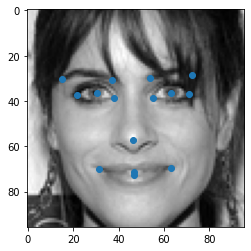

In [ ]:
show_image(X, y, 69)

CNN model

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', input_shape=(96, 96, 1)),
        layers.LeakyReLU(),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.LeakyReLU(),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(128),
        layers.ReLU(),
        layers.Dense(96),
        layers.ReLU(),
        layers.Dense(64),
        layers.ReLU(),
        layers.Dense(30)
    ])
    
    return model

In [ ]:
model = create_model()

model.compile(optimizer='adam',
              loss='huber_loss',
              metrics=['accuracy'])

# Creates a callback to save weights
checkpoint_path = "checkpoint01/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(X, y, batch_size=32, epochs=100, callbacks=[cp_callback])

Epoch 1/100
134/134 [==============================] - ETA: 0s - loss: 13.7954 - accuracy: 0.4621
Epoch 00001: saving model to checkpoint01/cp.ckpt
134/134 [==============================] - 8s 52ms/step - loss: 13.7954 - accuracy: 0.4621
Epoch 2/100
133/134 [============================>.] - ETA: 0s - loss: 5.9223 - accuracy: 0.6436
Epoch 00002: saving model to checkpoint01/cp.ckpt
134/134 [==============================] - 7s 50ms/step - loss: 5.9161 - accuracy: 0.6428
Epoch 3/100
133/134 [============================>.] - ETA: 0s - loss: 4.4418 - accuracy: 0.6396
Epoch 00003: saving model to checkpoint01/cp.ckpt
134/134 [==============================] - 7s 50ms/step - loss: 4.4421 - accuracy: 0.6404
Epoch 4/100
133/134 [============================>.] - ETA: 0s - loss: 3.7067 - accuracy: 0.6452
Epoch 00004: saving model to checkpoint01/cp.ckpt
134/134 [==============================] - 7s 50ms/step - loss: 3.7072 - accuracy: 0.6456
Epoch 5/100
133/134 [============================>

In [ ]:
# Shows predicted keypoints on image
def show_predicted_image(predictions, index):
    example = predictions[index, :]
    x_values = example[::2]
    y_values = example[1::2]
    example_image = images[index].reshape(96, 96)
    plt.imshow(example_image, cmap='gray')
    plt.scatter(x_values, y_values)
    plt.show()

In [ ]:
test_dataframe = get_test_df()
images = get_images(test_dataframe).reshape(1783, 96, 96, 1)

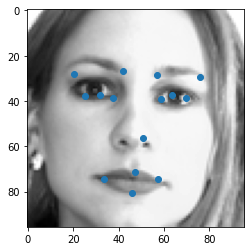

In [ ]:
predictions = model.predict(images)
show_predicted_image(predictions, 333)